In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

## 0. Data processing and visualization
1. Investigate the ratings.csv dataset, transform it to $(M,N)$ matrix so that each row represents a movie and each column represents a user. So M = number of unique movies, N = number of unique users. $r_{ij}$ is the rating j-th user gave to i-th movie.
2. Fill N/A values with 0.0
3. Investigate the resulting dataset, remove uninformative columns if any.
4. Perform exploratory analysis on the dataset.(correlation matrix, summary statistics barplots of features)

In [2]:
df = pd.read_csv('movielens_small_dataset/ratings.csv')
ratings = df.pivot_table(index='userId', columns='movieId', values='rating')
ratings.fillna(0.0, inplace=True)
ratings.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
std = ratings.describe().iloc[2, :]

In [4]:
for i, movie_std in enumerate(std):
    if movie_std == 0:
        print("Movie with Id {} has std = 0".format(i))

In [5]:
ratings.isnull().sum().sum()

0

In [6]:
# plt.figure(figsize=(15, 25))
# corr_data = ratings.corr()
# sn.heatmap(corr_data, annot=True)
# plt.show()

## 1. Reducing Dimentionality of Data
All clustering algorithms benefit from dimensionality reduction. In this task perform PCA and project the dataset to lower dimension. Preserve at least 0.9 of initial variance

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()
ss.fit(ratings)
X = ss.transform(ratings)

pca = PCA(n_components=0.9)
pca.fit(X)
X_transformed = pca.fit_transform(X)

In [8]:
pca.explained_variance_ratio_.sum()

0.9006161636908936

In [9]:
pca.n_components_

181

In [10]:
print(X.shape, X_transformed.shape)

(610, 9724) (610, 181)


## 2. Clustering
1. On the projected dataset fit KMeans, choose the best k from values $1,2,...,30$, report silhouette score of the best k
2. On the projected dataset decide minPts and eps, afterwards fit DBSCAN with chosen params, report the silhouette score
3. On the projected dataset fit 3 affinity propagation models, by setting preference to minimum of similarity matrix, mean of similarity matrix, median of similarity matrix.
Report the silhouette scores and choose the best one according to it.
4. Use scipy.cluster.hierarchy.linkage and scipy.cluster.hierarchy.dendrogram to plot dendrograms for [single, average, ward] linkages. Choose best k for each linkages from the dendrograms. Fit aglomerative clustering using the k-s that you chose. Report the three silhouette scores and choose the best model. Use the projected dataset for this task too.


#### 1. On the projected dataset fit KMeans, choose the best k from values  1,2,...,30 , report silhouette score of the best k

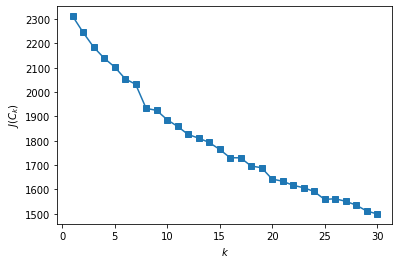

In [11]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_transformed)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(range(1, 31), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.show()

In [12]:
K = 20

from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=K)
cluster_labels = clusterer.fit_predict(X_transformed)
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("For n_clusters =", K, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 20 The average silhouette_score is : 0.6455821166681627


#### 2. On the projected dataset decide minPts and eps, afterwards fit DBSCAN with chosen params, report the silhouette score

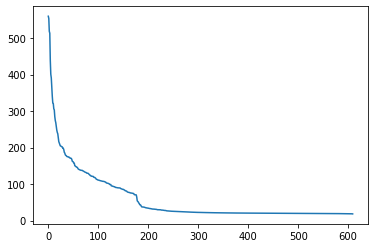

In [13]:
from sklearn.neighbors import KDTree

minPts = X_transformed.shape[1] * 2
tree = KDTree(X_transformed)
dist, ind = tree.query(X_transformed, k=minPts)
plt.plot(np.arange(X_transformed.shape[0]), -1 * np.sort(-1*dist.max(axis=1)))
plt.show()

In [14]:
from sklearn.cluster import DBSCAN

eps = 50

model = DBSCAN(eps=eps, min_samples=minPts)
cluster_labels = model.fit_predict(X_transformed)

silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("For eps =", eps, "and minPts = ", minPts,  "The average silhouette_score is :", silhouette_avg)

For eps = 50 and minPts =  362 The average silhouette_score is : 0.5210115320550337


#### 3. On the projected dataset fit 3 affinity propagation models, by setting preference to minimum of similarity matrix, mean of similarity matrix, median of similarity matrix. Report the silhouette scores and choose the best one according to it.

In [15]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity

af = AffinityPropagation(preference=-50).fit(X_transformed)
af_matrix = af.affinity_matrix_
preferences = {
    "similarity_min": af_matrix.min(),
    "similarity_max": af_matrix.max(),
    "similarity_median": np.median(af_matrix)
}

for i in preferences:
    preference = preferences[i]
    clustering = AffinityPropagation(preference=preference)
    cluster_labels = clustering.fit_predict(X_transformed)
    try:
        silhouette_avg = silhouette_score(X_transformed, cluster_labels)
        print("For preference =", preference, "The average silhouette_score is :", silhouette_avg)
    except ValueError:
        print("Silhouette_score requires more than 1, but < len(samples) cluster labels. In case of prefernece = {} len(labels) = {}".format(i, len(np.unique(cluster_labels))))
        

Silhouette_score requires more than 1, but < len(samples) cluster labels. In case of prefernece = similarity_min len(labels) = 1
Silhouette_score requires more than 1, but < len(samples) cluster labels. In case of prefernece = similarity_max len(labels) = 610
For preference = -2734.337216087921 The average silhouette_score is : 0.19185599460649713


#### 4. Use scipy.cluster.hierarchy.linkage and scipy.cluster.hierarchy.dendrogram to plot dendrograms for [single, average, ward] linkages. Choose best k for each linkages from the dendrograms. Fit aglomerative clustering using the k-s that you chose. Report the three silhouette scores and choose the best model. Use the projected dataset for this task too.

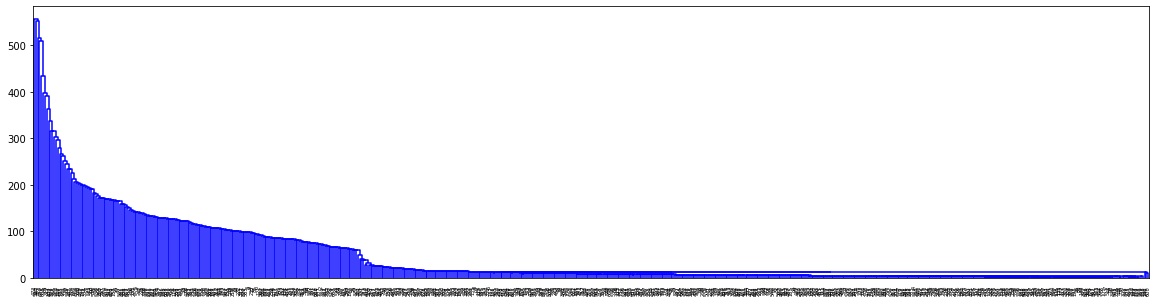

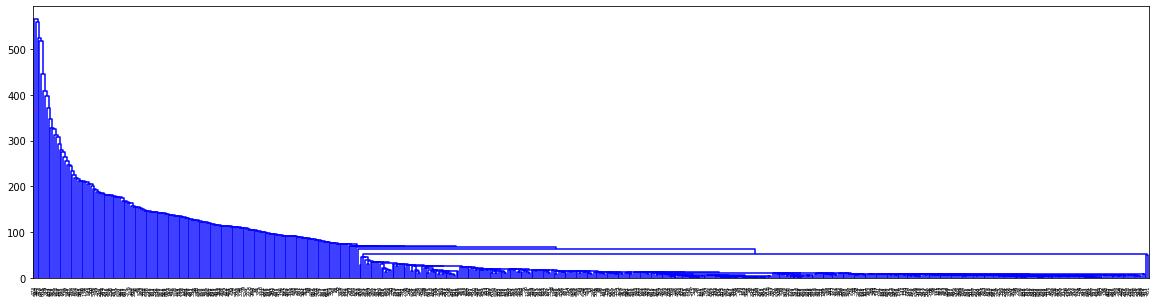

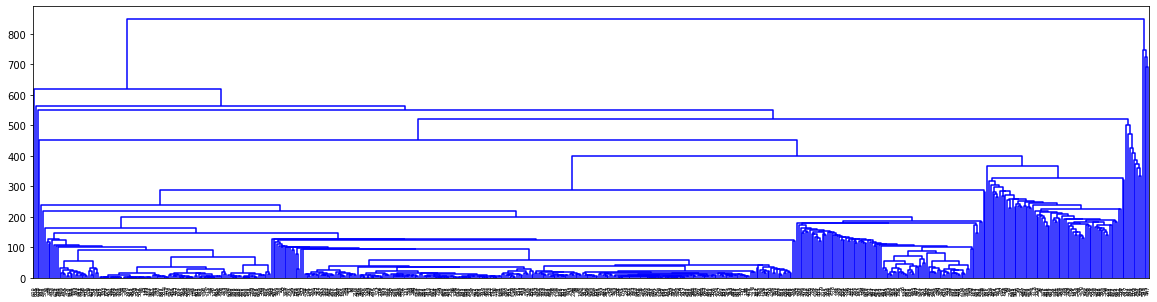

In [16]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist


distance_mat = pdist(X_transformed) 
Z = hierarchy.linkage(distance_mat, 'single')
Z1 = hierarchy.linkage(distance_mat, 'average')
Z2 = hierarchy.linkage(distance_mat, 'ward')
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)
plt.figure(figsize=(20, 5))
d1 = hierarchy.dendrogram(Z1, color_threshold=0.5)
plt.figure(figsize=(20, 5))
d2 = hierarchy.dendrogram(Z2, color_threshold=0.5)
plt.show()

In [17]:
K = 2
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=K)
cluster_labels = clustering.fit_predict(X_transformed)
silhouette_score(X_transformed, cluster_labels)


0.8423122159107869

## 3. Performing clustering and visualising the clusters
1. Use the projected dataset you got from task 1 project it to 2D using t-SNE(sklearn.manifold.TSNE). On the t-SNE projected dataset perform the same tasks as in task 2. 
2. Make four scatter plots for the four best models you got in task 3.1, by coloring points according to their cluster.
3. Using the model with the best silhouette score examine some movies that are in the same cluster, what do the clusters show?

In [18]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

# KMeans

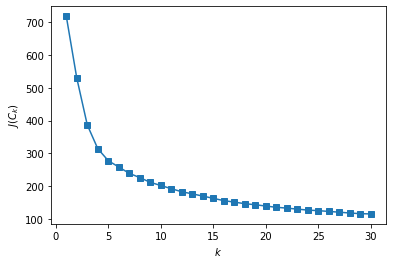

In [19]:
inertia = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_embedded)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(range(1, 31), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.show()

In [20]:
K = 5

from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=K)
cluster_labels_kmeans = clusterer.fit_predict(X_embedded)
silhouette_avg = silhouette_score(X_embedded, cluster_labels_kmeans)
print("For n_clusters =", K, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.8141688


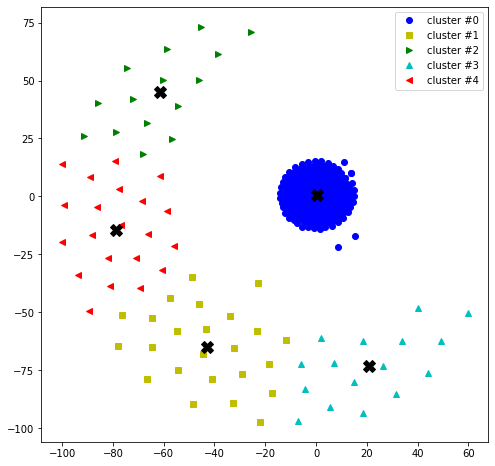

In [21]:
plt.figure(figsize=(8, 8))
colors = ['bo', 'ys', 'g>', 'c^', 'r<']
centers = clusterer.cluster_centers_

for i in range(K):
    plt.plot(X_embedded[cluster_labels_kmeans == i, 0], X_embedded[cluster_labels_kmeans == i, 1], colors[i], label=f'cluster #{i}')
    plt.plot(centers[i][0], centers[i][1], 'kX', markersize=12)
plt.legend(loc=0)
plt.show()

# DBSCAN

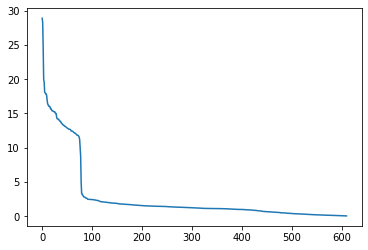

In [22]:
minPts = X_embedded.shape[1] * 2
tree = KDTree(X_embedded)
dist, ind = tree.query(X_embedded, k=minPts)
plt.plot(np.arange(X_embedded.shape[0]), -1 * np.sort(-1*dist.max(axis=1)))
plt.show()

In [49]:
eps = 3

model = DBSCAN(eps=eps, min_samples=minPts)
cluster_labels_dbscan = model.fit_predict(X_embedded)

silhouette_avg = silhouette_score(X_embedded, cluster_labels_dbscan)
print("For eps =", eps, "and minPts = ", minPts,  "The average silhouette_score is :", silhouette_avg)

For eps = 3 and minPts =  4 The average silhouette_score is : 0.7607303


0
1


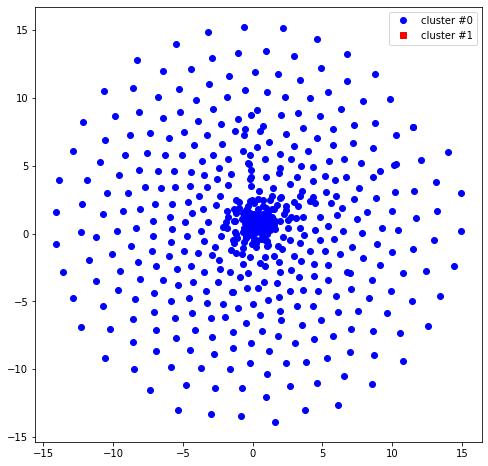

In [47]:
clusters = np.unique(cluster_labels_dbscan)

plt.figure(figsize=(8, 8))
colors = ['bo', 'rs']

for i, label in enumerate(clusters):
    print(label)
    plt.plot(X_embedded[cluster_labels_dbscan == label, 0], X_embedded[cluster_labels_dbscan == label, 1], colors[i], label=f'cluster #{i}')
plt.legend(loc=0)
plt.show()